In [ ]:
# 그래프 시각화 한글 처리
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

## 코드 실행 후 런타임 다시 시작 --> 해당 셀 제외하고 코드 실행

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import datetime
import scipy.stats

%matplotlib inline
plt.rc('font', family='NanumBarunGothic')

import warnings
warnings.filterwarnings(action='ignore')

전체 데이터에서 변경해야할 것
- 서울데이터만 남기고 제거
- 예매건수가 30이하인 공연 제거(미정)
  - 지금 본게 2022(1) 데이터 뿐이라서 지금 제거한 공연이 예매건수 30개 이하가 아닐 수도 있음
- (모델링 시) 사전예매 100%로 이루어진 공연
- 장애인석 N -> 0
- 공연일시, 예매/취소일시 : datetime 변경 후 시분초 제거
- 공연시작일자, 공연종료일자 : datetime으로 변경
- 판매시작일시, 판매종료일시 : 9999년 -> null -> datetime 변경
- 소요시간 : 1시간 40분 -> 100 처럼 문자열을 분을 뜻하는 정수형으로 변경
- 관람연령 데이터 변경
- 판매좌석수 : '석' 문자 제거 및 int로 변환 (NaN 값은 무시)
- 공연장 규모 컬럼 추가
- 예매/취소일시 : date와 hour 컬럼 만들기

할 것
- 평일/주말, 요일, 계절/월
- 사전예매 공연 top10, 당일예매 공연 top10

# 위도경도 행정동 붙이기

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [ ]:
longlat = pd.read_csv('/content/drive/MyDrive/KOPIS DATA/Data/csv/2019/2019_FC_long_lat.csv')
longlat = longlat.iloc[:, 1:]
longlat

,공연시설코드,시설특성,개관연도,주소,편의시설_레스토랑 여부,편의시설_카페 여부,편의시설_편의점 여부,편의시설_놀이방 여부,편의시설_수유실 여부,장애인시설_주차장 여부,장애인시설_화장실 여부,장애인시설_경사로 여부,장애인시설_전용엘리베이터 여부,주차시설_자체 여부,주차시설_공영 여부,x,y
0,FC223783,민간(대학로 외),2005.0,경상북도 구미시 구미대로22길 11,True,True,True,False,True,True,True,False,False,True,False,128.365409,36.113788
1,FC223076,공공(기타),2018.0,서울특별시 서대문구 연세로2나길 57,False,True,False,False,False,True,False,False,True,True,False,126.939755,37.557963
2,FC223757,민간(대학로 외),2017.0,서울특별시 종로구 인사동길 34-1,False,True,False,False,False,False,False,False,False,False,True,126.985610,37.573858
3,FC223315,공공(문예회관),1975.0,대구광역시 중구 태평로 141,False,True,False,False,True,True,True,True,True,True,False,128.593697,35.876059
4,FC224248,민간(대학로 외),NaN,서울특별시 강남구 학동로30길 43-7,False,False,False,False,False,False,False,False,False,False,True,127.033514,37.511618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071,FC224642,민간(대학로 외),2013.0,전라북도 군산시 중정길 17,False,False,False,False,False,False,False,False,False,False,True,126.713559,35.984803
1072,FC224645,기타(비공연장),NaN,서울특별시 종로구 인사동5길 42,True,False,False,False,False,False,False,False,False,True,False,126.983837,37.572450
1073,FC224484,민간(대학로 외),NaN,서울특별시 강남구 언주로 640,True,True,True,False,False,True,True,True,True,True,False,127.035885,37.514098
1074,FC224637,기타(비공연장),NaN,서울특별시 강남구 논현로79길 72,True,False,False,False,False,False,True,False,False,False,True,127.032882,37.496061


In [ ]:
dong_loc = gpd.read_file('/content/drive/MyDrive/KOPIS DATA/Data/Outsource/15.서울시_행정경계(읍면동).geojson')
dong_loc

,ADM_DR_CD,ADM_DR_NM,geometry
0,1101053,사직동,"MULTIPOLYGON (((126.97399 37.57823, 126.97400 ..."
1,1101054,삼청동,"MULTIPOLYGON (((126.97714 37.59768, 126.97730 ..."
2,1101055,부암동,"MULTIPOLYGON (((126.96173 37.60714, 126.96182 ..."
3,1101056,평창동,"MULTIPOLYGON (((126.97509 37.63118, 126.97488 ..."
4,1101057,무악동,"MULTIPOLYGON (((126.95975 37.58001, 126.96006 ..."
...,...,...,...
420,1125070,둔촌1동,"MULTIPOLYGON (((127.13664 37.52882, 127.13738 ..."
421,1125071,둔촌2동,"MULTIPOLYGON (((127.15656 37.53746, 127.15654 ..."
422,1125072,암사1동,"MULTIPOLYGON (((127.13568 37.55472, 127.13569 ..."
423,1125073,천호2동,"MULTIPOLYGON (((127.11633 37.55005, 127.11642 ..."


In [ ]:
def match_dong(row):
  point = Point(row['x'], row['y'])
  for poly in dong_loc.iterrows():
        if point.within(poly[1]['geometry']):
            return poly[1]['ADM_DR_NM'], poly[1]['ADM_DR_CD']
            break

In [ ]:
longlat[['dong_nm', 'dong_cd']] = longlat[['x', 'y']].apply(match_dong, axis=1, result_type='expand')

ValueError: ignored

In [ ]:
longlat

In [ ]:
longlat.to_csv('/content/drive/MyDrive/KOPIS DATA/Data/csv/2019/2019_FC_adm_dr_nm.csv', index=False)

In [ ]:
del longlat
del dong_loc

# 데이터 csv로 변경

In [ ]:
%cd /content/drive/MyDrive/KOPIS DATA/Data/

/content/drive/.shortcut-targets-by-id/1bzmosh_iZO8nu7Cyca6I-gDiO-RvmTg3/KOPIS DATA/Data


In [ ]:
import os

# 주어진 디렉토리에 있는 항목들의 이름을 담고 있는 리스트를 반환합니다.
# 리스트는 임의의 순서대로 나열됩니다.
file_path = '/content/drive/MyDrive/KOPIS DATA/Data/'
file_names = os.listdir(file_path)
file_names = file_names[3:]
file_names

['2022_10_01_05_720,803.xlsx',
 '2022_10_06_10_883,327.xlsx',
 '2022_10_11_15_606,033.xlsx',
 '2022_10_16_20_389,516.xlsx',
 '2022_10_21_25_683,404.xlsx',
 '2022_10_26_31_803,651.xlsx',
 '2022_11_01_05_445,105.xlsx',
 '2022_11_06_10_364,732.xlsx',
 '2022_11_11_15_666,241.xlsx',
 '2022_11_16_20_815,624.xlsx',
 '2022_11_21_25_317,479.xlsx',
 '2022_11_26_30_763,086.xlsx',
 '2022_12_01_05_887,980.xlsx',
 '2022_12_06_10_912,622.xlsx',
 '2022_12_11_16_715,942.xlsx',
 '2022_12_17_20_847,123.xlsx',
 '2022_12_21_23_565,793.xlsx',
 '2022_12_24_741,469.xlsx',
 '2022_12_25_28_738,967.xlsx',
 '2022_12_29_31_897,125.xlsx']

In [ ]:
len(file_names) # 20

20

In [ ]:
import pandas as pd
import os

def process_files_in_range(file_path, file_names, start_index, last_index, target_file):
    dfs = []
    for i in range(start_index, last_index):
        file = file_names[i]
        df = pd.read_excel(os.path.join(file_path, file))
        dfs.append(df)
        print(i,' 번째 append 완')

    merged_df = pd.concat(dfs, ignore_index=True)
    merged_df.to_csv(target_file, index=False)
    print(start_index,' 부터', last_index,' 까지', target_file,'로 CSV변경 완')


In [ ]:
file_path = '/content/drive/MyDrive/KOPIS DATA/Data/'
start_index = 0
last_index = 5
target_file = '/content/drive/MyDrive/KOPIS DATA/Data/csv/2022/2022(9).csv'
process_files_in_range(file_path, file_names, start_index, last_index, target_file)

0  번째 append 완
1  번째 append 완
2  번째 append 완
3  번째 append 완
4  번째 append 완
0  부터 5  까지 /content/drive/MyDrive/KOPIS DATA/Data/csv/2022/2022(9).csv 로 CSV변경 완


In [ ]:
file_path = '/content/drive/MyDrive/KOPIS DATA/Data/'
start_index = 5
last_index = 10
target_file = '/content/drive/MyDrive/KOPIS DATA/Data/csv/2022/2022(10).csv'
process_files_in_range(file_path, file_names, start_index, last_index, target_file)

5  번째 append 완
6  번째 append 완
7  번째 append 완
8  번째 append 완
9  번째 append 완
5  부터 10  까지 /content/drive/MyDrive/KOPIS DATA/Data/csv/2022/2022(10).csv 로 CSV변경 완


In [ ]:
file_path = '/content/drive/MyDrive/KOPIS DATA/Data/'
start_index = 10
last_index = 15
target_file = '/content/drive/MyDrive/KOPIS DATA/Data/csv/2022/2022(11).csv'
process_files_in_range(file_path, file_names, start_index, last_index, target_file)

10  번째 append 완
11  번째 append 완
12  번째 append 완
13  번째 append 완
14  번째 append 완
10  부터 15  까지 /content/drive/MyDrive/KOPIS DATA/Data/csv/2022/2022(11).csv 로 CSV변경 완


In [ ]:
file_path = '/content/drive/MyDrive/KOPIS DATA/Data/'
start_index = 15
last_index = 20
target_file = '/content/drive/MyDrive/KOPIS DATA/Data/csv/2022/2022(12).csv'
process_files_in_range(file_path, file_names, start_index, last_index, target_file)

15  번째 append 완
16  번째 append 완
17  번째 append 완
18  번째 append 완
19  번째 append 완
15  부터 20  까지 /content/drive/MyDrive/KOPIS DATA/Data/csv/2022/2022(12).csv 로 CSV변경 완


In [ ]:
file_path = '/content/drive/MyDrive/KOPIS DATA/Data/2022/'
file_names = sorted(os.listdir(file_path))
start_index = 20
last_index = 25
target_file = '/content/drive/MyDrive/KOPIS DATA/Data/csv/2022/2022(5).csv'
process_files_in_range(file_path, file_names, start_index, last_index, target_file)

20  번째 append 완
21  번째 append 완
22  번째 append 완
23  번째 append 완
24  번째 append 완
20  부터 25  까지 /content/drive/MyDrive/KOPIS DATA/Data/csv/2022/2022(5).csv 로 CSV변경 완


In [ ]:
file_path = '/content/drive/MyDrive/KOPIS DATA/Data/2022/'
file_names = sorted(os.listdir(file_path))
start_index = 25
last_index = 30
target_file = '/content/drive/MyDrive/KOPIS DATA/Data/csv/2022/2022(6).csv'
process_files_in_range(file_path, file_names, start_index, last_index, target_file)

25  번째 append 완
26  번째 append 완
27  번째 append 완
28  번째 append 완
29  번째 append 완
25  부터 30  까지 /content/drive/MyDrive/KOPIS DATA/Data/csv/2022/2022(6).csv 로 CSV변경 완


In [ ]:
file_path = '/content/drive/MyDrive/KOPIS DATA/Data/2022/'
file_names = sorted(os.listdir(file_path))
start_index = 30
last_index = 35
target_file = '/content/drive/MyDrive/KOPIS DATA/Data/csv/2022/2022(7).csv'
process_files_in_range(file_path, file_names, start_index, last_index, target_file)

30  번째 append 완
31  번째 append 완
32  번째 append 완
33  번째 append 완
34  번째 append 완
30  부터 35  까지 /content/drive/MyDrive/KOPIS DATA/Data/csv/2022/2022(7).csv 로 CSV변경 완


In [ ]:
file_path = '/content/drive/MyDrive/KOPIS DATA/Data/2022/'
file_names = sorted(os.listdir(file_path))
start_index = 35
last_index = 37
target_file = '/content/drive/MyDrive/KOPIS DATA/Data/csv/2022/2022(8).csv'
process_files_in_range(file_path, file_names, start_index, last_index, target_file)

35  번째 append 완
36  번째 append 완
35  부터 37  까지 /content/drive/MyDrive/KOPIS DATA/Data/csv/2022/2022(8).csv 로 CSV변경 완


# zip 파일 풀기

In [ ]:
%cd /content/drive/MyDrive/KOPIS DATA/Data

/content/drive/.shortcut-targets-by-id/1bzmosh_iZO8nu7Cyca6I-gDiO-RvmTg3/KOPIS DATA/Data


In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1bzmosh_iZO8nu7Cyca6I-gDiO-RvmTg3/KOPIS DATA/Data'

In [ ]:
!unzip -qq "/content/drive/MyDrive/KOPIS DATA/Data/2022_10_2022_12.zip"

In [ ]:
## 파일 이름 변경
import os

file_path = '/content/drive/MyDrive/KOPIS DATA/Data/'
file_names = os.listdir(file_path)
file_names[3:]

['(╡е└╠┼═)_19│т ╟╧╣▌▒т~ _22│т ╟╧╣▌▒т ░°╕Ё└№ raw╡е└╠┼═_2022_10_01_05_720,803.xlsx',
 '(╡е└╠┼═)_19│т ╟╧╣▌▒т~ _22│т ╟╧╣▌▒т ░°╕Ё└№ raw╡е└╠┼═_2022_10_06_10_883,327.xlsx',
 '(╡е└╠┼═)_19│т ╟╧╣▌▒т~ _22│т ╟╧╣▌▒т ░°╕Ё└№ raw╡е└╠┼═_2022_10_11_15_606,033.xlsx',
 '(╡е└╠┼═)_19│т ╟╧╣▌▒т~ _22│т ╟╧╣▌▒т ░°╕Ё└№ raw╡е└╠┼═_2022_10_16_20_389,516.xlsx',
 '(╡е└╠┼═)_19│т ╟╧╣▌▒т~ _22│т ╟╧╣▌▒т ░°╕Ё└№ raw╡е└╠┼═_2022_10_21_25_683,404.xlsx',
 '(╡е└╠┼═)_19│т ╟╧╣▌▒т~ _22│т ╟╧╣▌▒т ░°╕Ё└№ raw╡е└╠┼═_2022_10_26_31_803,651.xlsx',
 '(╡е└╠┼═)_19│т ╟╧╣▌▒т~ _22│т ╟╧╣▌▒т ░°╕Ё└№ raw╡е└╠┼═_2022_11_01_05_445,105.xlsx',
 '(╡е└╠┼═)_19│т ╟╧╣▌▒т~ _22│т ╟╧╣▌▒т ░°╕Ё└№ raw╡е└╠┼═_2022_11_06_10_364,732.xlsx',
 '(╡е└╠┼═)_19│т ╟╧╣▌▒т~ _22│т ╟╧╣▌▒т ░°╕Ё└№ raw╡е└╠┼═_2022_11_11_15_666,241.xlsx',
 '(╡е└╠┼═)_19│т ╟╧╣▌▒т~ _22│т ╟╧╣▌▒т ░°╕Ё└№ raw╡е└╠┼═_2022_11_16_20_815,624.xlsx',
 '(╡е└╠┼═)_19│т ╟╧╣▌▒т~ _22│т ╟╧╣▌▒т ░°╕Ё└№ raw╡е└╠┼═_2022_11_21_25_317,479.xlsx',
 '(╡е└╠┼═)_19│т ╟╧╣▌▒т~ _22│т ╟╧╣▌▒т ░°╕Ё└№ raw╡е└╠┼═_2022_11_26_30_763,086

In [ ]:
file_names[3:][0][53:]

'2022_10_01_05_720,803.xlsx'

In [ ]:
for filename in file_names[3:]:
  os.rename(filename, filename[53:])

# 데이터 클렌징

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/KOPIS DATA/Data/csv/2022/2022(1).csv')

## 서울만 남기기

In [ ]:
df = df[df['주소'].str.contains('서울')] # 서울만 남기기
df.reset_index(inplace=True, drop=True)
df.shape

(3070382, 68)

## 장애인석

In [ ]:
df['장애인석'].replace('N', 0, inplace=True) # 장애인석 'N' -> 0

## 공연일시, 예매/취소일시, 공연시작일자, 공연종료일자
- 공연일시 datetime으로 바꾸고 시분초 버리고 연월일만 남기기
- 예매/취소일시 datetime으로 바꾸고 예매/취소일시(연월일), 예매/취소시간(hour) 만들기
- 공연시작일자, 공연종료일자 datetime으로 변경

In [ ]:
df['공연일시'] = pd.to_datetime(df['공연일시'])
df['공연일시'] = df['공연일시'].dt.date
df['공연일시'] = pd.to_datetime(df['공연일시'])
df['예매/취소일시'] = pd.to_datetime(df['예매/취소일시'])
df['예매/취소시간'] = df['예매/취소일시'].apply(lambda dt: dt.strftime('%H:%M')).str[:2] + ':00'
df['예매/취소일시'] = df['예매/취소일시'].dt.date
df['예매/취소일시'] = pd.to_datetime(df['예매/취소일시'])

df['공연시작일자'] = pd.to_datetime(df['공연시작일자'])
df['공연종료일자'] = pd.to_datetime(df['공연종료일자'])

In [ ]:
#df.iloc[:, [28, 68]]

,예매/취소일시,예매/취소시간
0,2021-12-15,08:00
1,2021-12-16,08:00
2,2021-12-28,15:00
3,2021-12-29,23:00
4,2021-10-25,15:00
...,...,...
3070377,2022-02-18,19:00
3070378,2022-02-18,19:00
3070379,2022-02-18,19:00
3070380,2022-02-18,19:00


## 판매시작일시, 판매종료일시
- 9999년으로 시작하는 데이터들은 null로 변경 후 datetime 형식으로 변경

In [ ]:
#print(df['판매시작일시'].isnull().sum())
#print(df['판매종료일시'].isnull().sum())

2288
2288


In [ ]:
#df['판매시작일시'].sort_values(ascending=False)[:10] # 9999인 경우 null 처리

1029363    9999/12/31 12:00:00
385465     9999/12/31 12:00:00
2628282    9999/12/31 12:00:00
2628283    9999/12/31 12:00:00
2628284    9999/12/31 12:00:00
2628285    9999/12/31 12:00:00
2628286    9999/12/31 12:00:00
2628287    9999/12/31 12:00:00
2628288    9999/12/31 12:00:00
2628289    9999/12/31 12:00:00
Name: 판매시작일시, dtype: object

In [ ]:
df['판매시작일시'] = df['판매시작일시'].apply(lambda x: np.nan if pd.notna(x) and '9999' in x else x)
df['판매종료일시'] = df['판매종료일시'].apply(lambda x: np.nan if pd.notna(x) and '9999' in x else x)

In [ ]:
#print(df['판매시작일시'].isnull().sum())
#print(df['판매종료일시'].isnull().sum())

In [ ]:
df['판매시작일시'] = pd.to_datetime(df['판매시작일시'])
df['판매종료일시'] = pd.to_datetime(df['판매종료일시'])
df['판매시작일시'] = df['판매시작일시'].dt.date
df['판매종료일시'] = df['판매종료일시'].dt.date
df['판매시작일시'] = pd.to_datetime(df['판매시작일시'])
df['판매종료일시'] = pd.to_datetime(df['판매종료일시'])

In [ ]:
df['판매종료일시']

0         2022-02-27
1         2022-02-27
2         2022-02-27
3         2022-02-27
4         2021-12-31
             ...    
3070377   2022-02-19
3070378   2022-02-19
3070379   2022-02-19
3070380   2022-02-19
3070381   2022-02-19
Name: 판매종료일시, Length: 3070382, dtype: datetime64[ns]

## 소요시간
- 1시간 30분 -> 90
- 숫자와 문자가 섞여있는 형식에서 분을 뜻하는 numeric으로 변경

In [ ]:
#df['소요시간']

0              40분
1              40분
2              40분
3              40분
4           1시간 5분
            ...   
3070377    2시간 55분
3070378    2시간 55분
3070379    2시간 55분
3070380    2시간 55분
3070381    2시간 55분
Name: 소요시간, Length: 3070382, dtype: object

In [ ]:
import re

In [ ]:
# 소요시간을 분 단위로 변환하는 함수
def convert_to_minutes(time_str):
    if pd.notna(time_str):
        hours = re.findall(r'\d+시간', time_str)
        minutes = re.findall(r'\d+분', time_str)

        total_minutes = 0
        if hours:
            total_minutes += int(hours[0].replace('시간', '')) * 60
        if minutes:
            total_minutes += int(minutes[0].replace('분', ''))

        return total_minutes
    else:
        return None

In [ ]:
df['소요시간'] = df['소요시간'].apply(convert_to_minutes)

In [ ]:
df['소요시간']

0           40.0
1           40.0
2           40.0
3           40.0
4           65.0
           ...  
3070377    175.0
3070378    175.0
3070379    175.0
3070380    175.0
3070381    175.0
Name: 소요시간, Length: 3070382, dtype: float64

## 관람연령

- 24개월 이상 -> 만 2세 이상
- 36개월 이상 -> 만 3세 이상
- 12개월 이상 -> 만 1세 이상
- 만 12세 드림아트센터이상 -> 만 12세 이상
- 48개월 이상 -> 만 4세 이상
- 전체 관람가 -> 전체
- 미학아동입장불가 -> 만 7세 이상

In [ ]:
#df['관람연령'].value_counts()

만 13세 이상          1166001
만 7세 이상           1158018
24개월 이상            136700
만 14세 이상            97278
만 11세 이상            64279
36개월 이상             61849
전체 관람가              59766
12개월 이상             51510
만 12세 이상            46718
만 19세 이상            31230
만 16세 이상            28322
만 18세 이상            26984
만 8세 이상             24111
만 12세 드림아트센터이상      23903
만 15세 이상            21123
만 17세 이상            20349
20개월 이상             14012
만 5세 이상             10668
만 6세 이상              7895
48개월 이상              7618
만 10세 이상             6270
만 7세이상               2440
만 9세 이상              1245
만 4세 이상               620
전체                    372
40개월 이상               282
미학아동입장불가                2
Name: 관람연령, dtype: int64

In [ ]:
df['관람연령'].replace('24개월 이상', '만 2세 이상', inplace=True)
df['관람연령'].replace('36개월 이상', '만 3세 이상', inplace=True)
df['관람연령'].replace('12개월 이상', '만 1세 이상', inplace=True)
df['관람연령'].replace('만 12세 드림아트센터이상', '만 12세 이상', inplace=True)
df['관람연령'].replace('48개월 이상', '만 4세 이상', inplace=True)
df['관람연령'].replace('전체 관람가', '전체', inplace=True)
df['관람연령'].replace('미학아동입장불가', '만 7세 이상', inplace=True)

In [ ]:
#df['관람연령'].value_counts()

만 13세 이상    1166001
만 7세 이상     1158020
만 2세 이상      136700
만 14세 이상      97278
만 12세 이상      70621
만 11세 이상      64279
만 3세 이상       61849
전체            60138
만 1세 이상       51510
만 19세 이상      31230
만 16세 이상      28322
만 18세 이상      26984
만 8세 이상       24111
만 15세 이상      21123
만 17세 이상      20349
20개월 이상       14012
만 5세 이상       10668
만 4세 이상        8238
만 6세 이상        7895
만 10세 이상       6270
만 7세이상         2440
만 9세 이상        1245
40개월 이상         282
Name: 관람연령, dtype: int64

## 판매좌석수
- '석'이라는 문자 제거

In [ ]:
#df['판매좌석수']

0              1
1              1
2              1
3              1
4           335석
           ...  
3070377    5000석
3070378    5000석
3070379    5000석
3070380    5000석
3070381    5000석
Name: 판매좌석수, Length: 3070382, dtype: object

In [ ]:
# '석' 문자 제거 및 int로 변환 (NaN 값은 무시)
df['판매좌석수'] = pd.to_numeric(df['판매좌석수'].str.replace('석', ''), errors='coerce').astype(pd.Int32Dtype())

In [ ]:
#df['판매좌석수']

0             1
1             1
2             1
3             1
4           335
           ... 
3070377    5000
3070378    5000
3070379    5000
3070380    5000
3070381    5000
Name: 판매좌석수, Length: 3070382, dtype: Int32

In [ ]:
#df['판매좌석수'].describe()

count       2980508.0
mean      2509.534264
std      12099.576576
min               0.0
25%             155.0
50%             502.0
75%            1214.0
max          213366.0
Name: 판매좌석수, dtype: Float64

## 당일예매/취소구분
- 당일예매/취소 새로운 열 생성
- 공연일시와 예매/취소일시가 같으면 1 다르면 0

In [ ]:
df['당일예매/취소'] = df.apply(lambda x: 1 if (x['공연일시']==x['예매/취소일시']) else 0, axis=1)

In [ ]:
#df['당일예매/취소'].value_counts()

0    2713161
1     357221
Name: 당일예매/취소, dtype: int64

In [ ]:
#df.iloc[:, [24, 26, 28, 29, 69]]

,공연코드,공연일시,예매/취소일시,예매/취소구분,당일예매/취소
0,PF306057,2022-01-01,2021-12-15,1,0
1,PF306057,2022-01-01,2021-12-16,2,0
2,PF306057,2022-01-01,2021-12-28,1,0
3,PF306057,2022-01-01,2021-12-29,2,0
4,PF303848,2022-01-01,2021-10-25,1,0
...,...,...,...,...,...
3070377,PF391165,2022-02-20,2022-02-18,1,0
3070378,PF391165,2022-02-20,2022-02-18,1,0
3070379,PF391165,2022-02-20,2022-02-18,1,0
3070380,PF391165,2022-02-20,2022-02-18,1,0


## 공연장 규모
- 좌석수에 따른 공연장 규모 새로운 열 생성
- 1 : 100석 미만
- 2 : 100~300석 미만
- 3 : 300~500석 미만
- 4 : 500~1000석 미만
- 5 : 1000석 이상

In [ ]:
conditions = [
    (df['좌석수'] < 100),
    (df['좌석수'] < 300),
    (df['좌석수'] < 500),
    (df['좌석수'] < 1000),
    (df['좌석수'] >= 1000)
]
choices = [1, 2, 3, 4, 5]

In [ ]:
df['공연장규모'] = np.select(conditions, choices, default=None)

In [ ]:
#df['공연장규모'].value_counts()

5    1748443
2     539880
4     395631
3     367344
1      19084
Name: 공연장규모, dtype: int64

# 요일, 평일/주말, 계절/월별 당일예매 이용객

## 2022

In [ ]:
%cd /content/drive/MyDrive/KOPIS DATA/Data/csv/2022

/content/drive/.shortcut-targets-by-id/1bzmosh_iZO8nu7Cyca6I-gDiO-RvmTg3/KOPIS DATA/Data/csv/2022


In [ ]:
df = pd.read_csv('2022(1).csv', usecols=[24, 26, 28, 29])
df

,공연코드,공연일시,예매/취소일시,예매/취소구분
0,PF306057,2022-01-01 10:30,2021-12-15 08:48,1
1,PF306057,2022-01-01 10:30,2021-12-16 08:49,2
2,PF306057,2022-01-01 10:30,2021-12-28 15:03,1
3,PF306057,2022-01-01 10:30,2021-12-29 23:04,2
4,PF303848,2022-01-01 11:00,2021-10-25 15:43,1
...,...,...,...,...
3777473,PF391165,2022-02-20 23:59,2022-02-18 19:24,1
3777474,PF391165,2022-02-20 23:59,2022-02-18 19:25,1
3777475,PF391165,2022-02-20 23:59,2022-02-18 19:25,1
3777476,PF391165,2022-02-20 23:59,2022-02-18 19:28,1


In [ ]:
dfs = []
for i in range(1, 13):
  file_name = f'2022({i}).csv'
  df = pd.read_csv(file_name, usecols=[24, 26, 28, 29])
  df['공연일시'] = pd.to_datetime(df['공연일시'])
  df['공연일시'] = df['공연일시'].dt.date
  df['예매/취소일시'] = pd.to_datetime(df['예매/취소일시'])
  df['예매/취소일시'] = df['예매/취소일시'].dt.date
  df['당일예매/취소'] = df.apply(lambda x: 1 if (x['공연일시']==x['예매/취소일시']) else 0, axis=1)
  df = df[(df['예매/취소구분']==1) & (df['당일예매/취소']==1)]
  df = df[['공연코드', '공연일시']]
  dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

In [ ]:
combined_df

,공연코드,공연일시
0,PF303848,2022-01-01
1,PF303848,2022-01-01
2,PF303848,2022-01-01
3,PF303848,2022-01-01
4,PF303848,2022-01-01
...,...,...
2561131,PF425243,2022-12-31
2561132,PF425243,2022-12-31
2561133,PF425243,2022-12-31
2561134,PF425243,2022-12-31


In [ ]:
combined_df['공연일시'] = pd.to_datetime(combined_df['공연일시'])

In [ ]:
# 요일 파생변수
combined_df['요일'] = combined_df['공연일시'].dt.day_name()

# 평일/주말 파생변수
combined_df['평일_주말'] = combined_df['공연일시'].dt.dayofweek.apply(lambda x: '평일' if x < 5 else '주말')

# 월 파생변수
combined_df['월'] = combined_df['공연일시'].dt.month

# 계절 파생변수
def get_season(month):
    if 3 <= month <= 5:
        return '봄'
    elif 6 <= month <= 8:
        return '여름'
    elif 9 <= month <= 11:
        return '가을'
    else:
        return '겨울'

combined_df['계절'] = combined_df['공연일시'].dt.month.apply(get_season)

In [ ]:
combined_df

,공연코드,공연일시,요일,평일_주말,월,계절
0,PF303848,2022-01-01,Saturday,주말,1,겨울
1,PF303848,2022-01-01,Saturday,주말,1,겨울
2,PF303848,2022-01-01,Saturday,주말,1,겨울
3,PF303848,2022-01-01,Saturday,주말,1,겨울
4,PF303848,2022-01-01,Saturday,주말,1,겨울
...,...,...,...,...,...,...
2561131,PF425243,2022-12-31,Saturday,주말,12,겨울
2561132,PF425243,2022-12-31,Saturday,주말,12,겨울
2561133,PF425243,2022-12-31,Saturday,주말,12,겨울
2561134,PF425243,2022-12-31,Saturday,주말,12,겨울


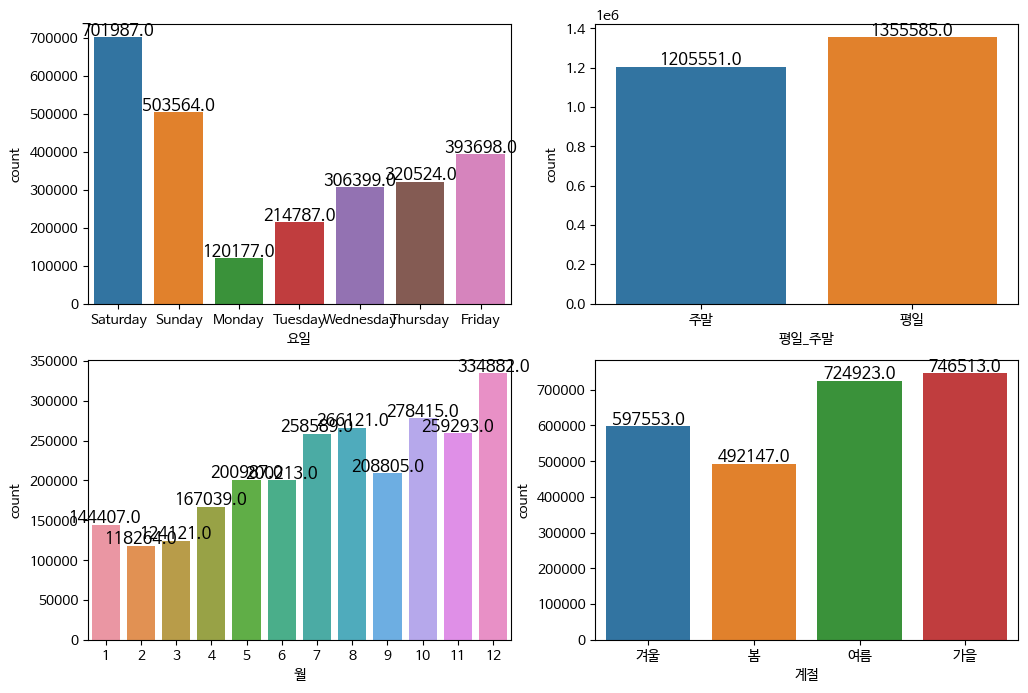

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,8))
a = sns.countplot(x='요일', data=combined_df, ax=ax[0, 0])
for p in a.patches:
    a.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
b = sns.countplot(x='평일_주말', data=combined_df, ax=ax[0, 1])
for p in b.patches:
    b.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
c=sns.countplot(x='월', data=combined_df, ax=ax[1, 0])
for p in c.patches:
    c.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
d=sns.countplot(x='계절', data=combined_df, ax=ax[1, 1])
for p in d.patches:
    d.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()

## 2021

In [ ]:
%cd /content/drive/MyDrive/KOPIS DATA/Data/csv/2021

/content/drive/.shortcut-targets-by-id/1bzmosh_iZO8nu7Cyca6I-gDiO-RvmTg3/KOPIS DATA/Data/csv/2021


In [ ]:
dfs = []
for i in range(1, 7):
  file_name = f'2021({i}).csv'
  df = pd.read_csv(file_name, usecols=[24, 26, 28, 29])
  df['공연일시'] = pd.to_datetime(df['공연일시'])
  df['공연일시'] = df['공연일시'].dt.date
  df['예매/취소일시'] = pd.to_datetime(df['예매/취소일시'])
  df['예매/취소일시'] = df['예매/취소일시'].dt.date
  df['당일예매/취소'] = df.apply(lambda x: 1 if (x['공연일시']==x['예매/취소일시']) else 0, axis=1)
  df = df[(df['예매/취소구분']==1) & (df['당일예매/취소']==1)]
  df = df[['공연코드', '공연일시']]
  dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

In [ ]:
combined_df

,공연코드,공연일시
0,PF364229,2021-01-01
1,PF364229,2021-01-01
2,PF364229,2021-01-01
3,PF357180,2021-01-01
4,PF357180,2021-01-01
...,...,...
1265009,PF350515,2021-12-25
1265010,PF350515,2021-12-25
1265011,PF350515,2021-12-25
1265012,PF350515,2021-12-25


In [ ]:
combined_df['공연일시'] = pd.to_datetime(combined_df['공연일시'])

In [ ]:
# 요일 파생변수
combined_df['요일'] = combined_df['공연일시'].dt.day_name()

# 평일/주말 파생변수
combined_df['평일_주말'] = combined_df['공연일시'].dt.dayofweek.apply(lambda x: '평일' if x < 5 else '주말')

# 월 파생변수
combined_df['월'] = combined_df['공연일시'].dt.month

# 계절 파생변수
def get_season(month):
    if 3 <= month <= 5:
        return '봄'
    elif 6 <= month <= 8:
        return '여름'
    elif 9 <= month <= 11:
        return '가을'
    else:
        return '겨울'

combined_df['계절'] = combined_df['공연일시'].dt.month.apply(get_season)

In [ ]:
combined_df

,공연코드,공연일시,요일,평일_주말,월,계절
0,PF364229,2021-01-01,Friday,평일,1,겨울
1,PF364229,2021-01-01,Friday,평일,1,겨울
2,PF364229,2021-01-01,Friday,평일,1,겨울
3,PF357180,2021-01-01,Friday,평일,1,겨울
4,PF357180,2021-01-01,Friday,평일,1,겨울
...,...,...,...,...,...,...
1265009,PF350515,2021-12-25,Saturday,주말,12,겨울
1265010,PF350515,2021-12-25,Saturday,주말,12,겨울
1265011,PF350515,2021-12-25,Saturday,주말,12,겨울
1265012,PF350515,2021-12-25,Saturday,주말,12,겨울


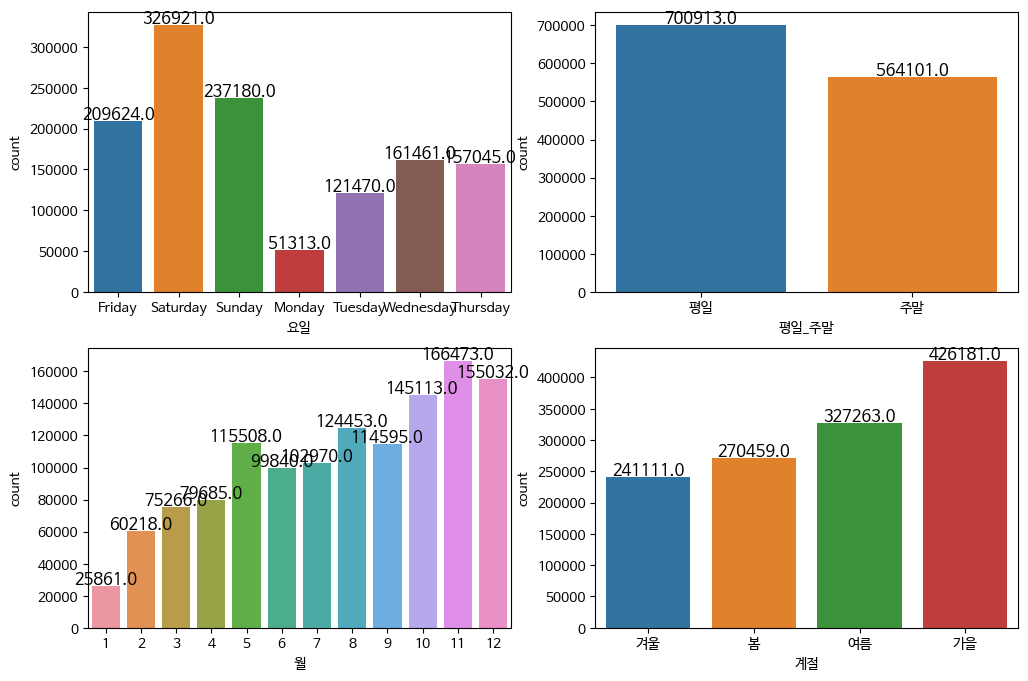

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,8))
a = sns.countplot(x='요일', data=combined_df, ax=ax[0, 0])
for p in a.patches:
    a.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
b = sns.countplot(x='평일_주말', data=combined_df, ax=ax[0, 1])
for p in b.patches:
    b.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
c=sns.countplot(x='월', data=combined_df, ax=ax[1, 0])
for p in c.patches:
    c.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
d=sns.countplot(x='계절', data=combined_df, ax=ax[1, 1])
for p in d.patches:
    d.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()

## 2020

In [ ]:
%cd /content/drive/MyDrive/KOPIS DATA/Data/csv/2020

/content/drive/.shortcut-targets-by-id/1bzmosh_iZO8nu7Cyca6I-gDiO-RvmTg3/KOPIS DATA/Data/csv/2020


In [ ]:
dfs = []
for i in range(1, 6):
  file_name = f'2020_{i}.csv'
  df = pd.read_csv(file_name, usecols=[24, 26, 28, 29])
  df['공연일시'] = pd.to_datetime(df['공연일시'])
  df['공연일시'] = df['공연일시'].dt.date
  df['예매/취소일시'] = pd.to_datetime(df['예매/취소일시'])
  df['예매/취소일시'] = df['예매/취소일시'].dt.date
  df['당일예매/취소'] = df.apply(lambda x: 1 if (x['공연일시']==x['예매/취소일시']) else 0, axis=1)
  df = df[(df['예매/취소구분']==1) & (df['당일예매/취소']==1)]
  df = df[['공연코드', '공연일시']]
  dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

In [ ]:
combined_df

,공연코드,공연일시
0,PF392378,2020-12-16
1,PF392378,2020-12-16
2,PF392378,2020-12-16
3,PF392378,2020-12-16
4,PF392378,2020-12-16
...,...,...
1244507,PF351198,2020-01-08
1244508,PF351198,2020-01-10
1244509,PF351198,2020-01-10
1244510,PF351198,2020-01-10


In [ ]:
combined_df['공연일시'] = pd.to_datetime(combined_df['공연일시'])

In [ ]:
# 요일 파생변수
combined_df['요일'] = combined_df['공연일시'].dt.day_name()

# 평일/주말 파생변수
combined_df['평일_주말'] = combined_df['공연일시'].dt.dayofweek.apply(lambda x: '평일' if x < 5 else '주말')

# 월 파생변수
combined_df['월'] = combined_df['공연일시'].dt.month

# 계절 파생변수
def get_season(month):
    if 3 <= month <= 5:
        return '봄'
    elif 6 <= month <= 8:
        return '여름'
    elif 9 <= month <= 11:
        return '가을'
    else:
        return '겨울'

combined_df['계절'] = combined_df['공연일시'].dt.month.apply(get_season)

In [ ]:
combined_df

,공연코드,공연일시,요일,평일_주말,월,계절
0,PF392378,2020-12-16,Wednesday,평일,12,겨울
1,PF392378,2020-12-16,Wednesday,평일,12,겨울
2,PF392378,2020-12-16,Wednesday,평일,12,겨울
3,PF392378,2020-12-16,Wednesday,평일,12,겨울
4,PF392378,2020-12-16,Wednesday,평일,12,겨울
...,...,...,...,...,...,...
1244507,PF351198,2020-01-08,Wednesday,평일,1,겨울
1244508,PF351198,2020-01-10,Friday,평일,1,겨울
1244509,PF351198,2020-01-10,Friday,평일,1,겨울
1244510,PF351198,2020-01-10,Friday,평일,1,겨울


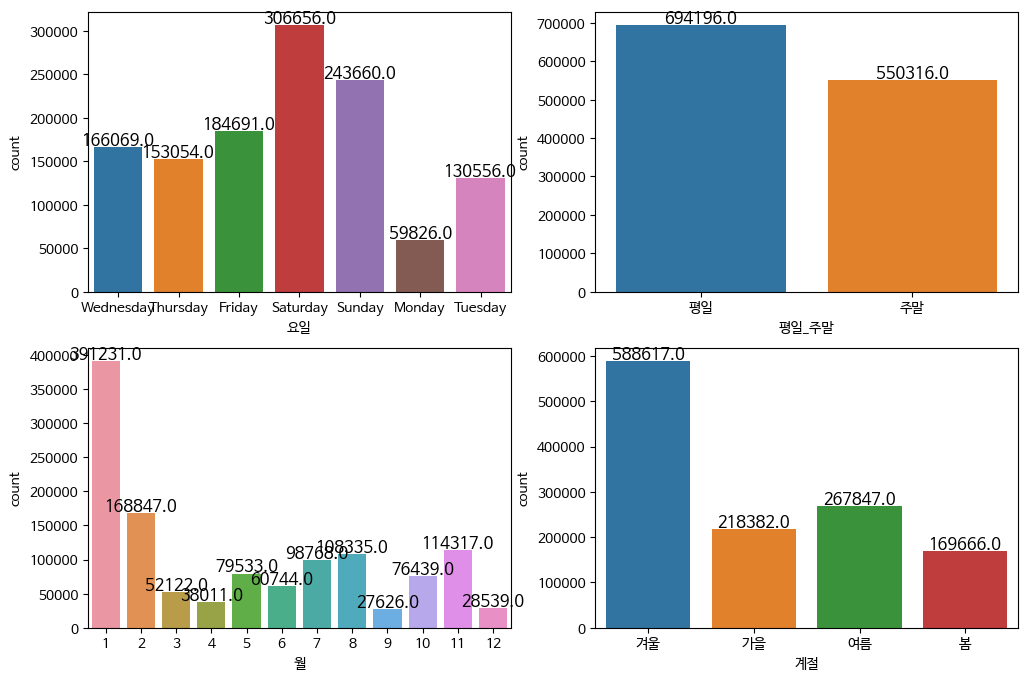

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,8))
a = sns.countplot(x='요일', data=combined_df, ax=ax[0, 0])
for p in a.patches:
    a.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
b = sns.countplot(x='평일_주말', data=combined_df, ax=ax[0, 1])
for p in b.patches:
    b.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
c=sns.countplot(x='월', data=combined_df, ax=ax[1, 0])
for p in c.patches:
    c.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
d=sns.countplot(x='계절', data=combined_df, ax=ax[1, 1])
for p in d.patches:
    d.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()

## 2019

In [ ]:
%cd /content/drive/MyDrive/KOPIS DATA/Data/csv/2019

/content/drive/.shortcut-targets-by-id/1bzmosh_iZO8nu7Cyca6I-gDiO-RvmTg3/KOPIS DATA/Data/csv/2019


In [ ]:
dfs = []
for i in range(1, 6):
  file_name = f'2019({i}).csv'
  df = pd.read_csv(file_name, usecols=[24, 26, 28, 29])
  df['공연일시'] = pd.to_datetime(df['공연일시'])
  df['공연일시'] = df['공연일시'].dt.date
  df['예매/취소일시'] = pd.to_datetime(df['예매/취소일시'])
  df['예매/취소일시'] = df['예매/취소일시'].dt.date
  df['당일예매/취소'] = df.apply(lambda x: 1 if (x['공연일시']==x['예매/취소일시']) else 0, axis=1)
  df = df[(df['예매/취소구분']==1) & (df['당일예매/취소']==1)]
  df = df[['공연코드', '공연일시']]
  dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

In [ ]:
combined_df

,공연코드,공연일시
0,PF361234,2019-07-06
1,PF361234,2019-07-06
2,PF360713,2019-07-02
3,PF360713,2019-07-02
4,PF360713,2019-07-02
...,...,...
2476546,PF374282,2019-12-31
2476547,PF374282,2019-12-31
2476548,PF374282,2019-12-31
2476549,PF374282,2019-12-31


In [ ]:
combined_df['공연일시'] = pd.to_datetime(combined_df['공연일시'])

In [ ]:
# 요일 파생변수
combined_df['요일'] = combined_df['공연일시'].dt.day_name()

# 평일/주말 파생변수
combined_df['평일_주말'] = combined_df['공연일시'].dt.dayofweek.apply(lambda x: '평일' if x < 5 else '주말')

# 월 파생변수
combined_df['월'] = combined_df['공연일시'].dt.month

# 계절 파생변수
def get_season(month):
    if 3 <= month <= 5:
        return '봄'
    elif 6 <= month <= 8:
        return '여름'
    elif 9 <= month <= 11:
        return '가을'
    else:
        return '겨울'

combined_df['계절'] = combined_df['공연일시'].dt.month.apply(get_season)

In [ ]:
combined_df

,공연코드,공연일시,요일,평일_주말,월,계절
0,PF361234,2019-07-06,Saturday,주말,7,여름
1,PF361234,2019-07-06,Saturday,주말,7,여름
2,PF360713,2019-07-02,Tuesday,평일,7,여름
3,PF360713,2019-07-02,Tuesday,평일,7,여름
4,PF360713,2019-07-02,Tuesday,평일,7,여름
...,...,...,...,...,...,...
2476546,PF374282,2019-12-31,Tuesday,평일,12,겨울
2476547,PF374282,2019-12-31,Tuesday,평일,12,겨울
2476548,PF374282,2019-12-31,Tuesday,평일,12,겨울
2476549,PF374282,2019-12-31,Tuesday,평일,12,겨울


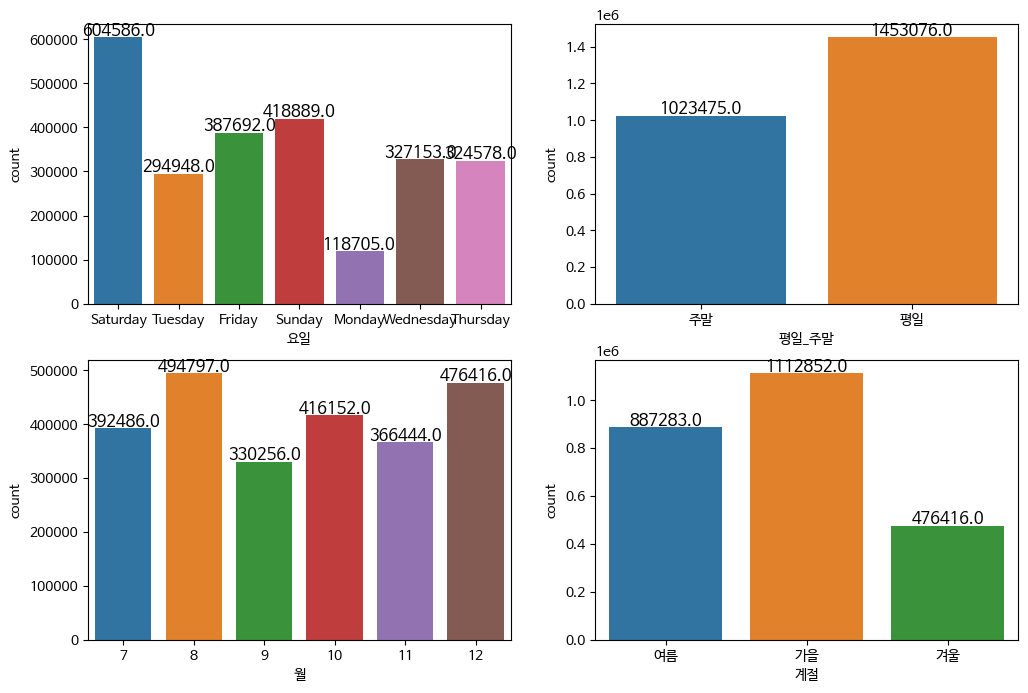

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,8))
a = sns.countplot(x='요일', data=combined_df, ax=ax[0, 0])
for p in a.patches:
    a.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
b = sns.countplot(x='평일_주말', data=combined_df, ax=ax[0, 1])
for p in b.patches:
    b.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
c=sns.countplot(x='월', data=combined_df, ax=ax[1, 0])
for p in c.patches:
    c.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
d=sns.countplot(x='계절', data=combined_df, ax=ax[1, 1])
for p in d.patches:
    d.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()